In [1]:
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import os
import soundfile as sf
from scipy.signal import butter, filtfilt

# 載入音訊檔案

In [2]:
# 指定存放 WAV 檔案的根目錄
wav_directory = "train_dataset"
target_sample_rate = 51200
def load_wav_files(directory, target_sr=16000):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        with tqdm(total=len(files), desc='Loading files', unit='file') as pbar:
            for file in files:
                if file.endswith(".wav") and file != 'all_channel.wav':
                    file_path = os.path.join(root, file)
                    y, sr = librosa.load(file_path, sr=None)
                    if sr != target_sr:
                        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
                    # remove wav_directory from root
                    path = root.split(os.path.sep)
                    filename = f'{path[1]}_{file}'
                    pbar.set_postfix(file=filename,)
                    wav_files.append((y, filename))
                pbar.update(1)
    return wav_files

def highpass_filter(wav_data, sr, cutoff=100, order=5):
    """
    Apply a high-pass filter to the audio signal to remove low-frequency noise like wind noise.

    :param wav_data: Audio time series and file name tuple
    :param sr: Sample rate
    :param cutoff: Cutoff frequency for the high-pass filter
    :param order: Order of the filter
    :return: Filtered audio time series
    """
    y, file_name = wav_data
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y)
    return y_filtered, file_name


In [3]:
loaded_files = load_wav_files(wav_directory, target_sr=target_sample_rate)

Loading files: 0file [00:00, ?file/s]
Loading files: 100%|██████████| 10/10 [00:00<00:00, 34.89file/s, file=wang-kong-normal_9.wav]


In [4]:
# 播放重新採樣後的音訊檔案
print(f'Number of files: {len(loaded_files)}, Sample rate: {target_sample_rate}, loaded_files[0]: {loaded_files[0][1]}')
display.Audio(loaded_files[0][0], rate=target_sample_rate)

Number of files: 10, Sample rate: 51200, loaded_files[0]: wang-kong-normal_1.wav


In [5]:
highpass_audio = [highpass_filter(y, sr=target_sample_rate, cutoff=220) for y in loaded_files]
display.Audio(highpass_audio[0][0], rate=target_sample_rate)

# 轉換音訊檔案為 Mel-Spectrogram

In [6]:
def convert_to_mel_spectrogram(y, n_fft, hop_length, n_mels, sr=16000, fmax=12800):
    audio = np.array(y)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels, fmin=25, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db


def extract_mfcc(y, sr=16000, n_mfcc=13, dct_type=2, norm='ortho', lifter=0, n_fft=2048, hop_length=512, n_mels=128, fmax=12800):

    """
    :param y: audio time series
    :param sr: sample rate
    :param n_mfcc: number of MFCC coefficients (excluding the 0th coefficient)
    :param dct_type: type of DCT used - 1 or 2 (default 2)
    :param norm: normalization technique - None or 'ortho' (default 'ortho')
    :param lifter: apply liftering to final MFCC coefficients (default 0)
    :param n_fft: length of the FFT window (default 2048)
    :param hop_length: number of samples between successive frames (default 512)
    :param n_mels: number of Mel bands to generate (default 128)
    :param fmax: highest frequency (in Hz) (default 16000)
    :return: MFCC coefficients (including the 0th coefficient)
    """
    mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, dct_type=dct_type, norm=norm, lifter=lifter,
                                     n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax, fmin=25)

    # Convert to decibel scale and add the 0th coefficient (log energy)
    mfcc_feat = librosa.power_to_db(mfcc_feat, ref=np.max)
    mfcc_feat = np.vstack((mfcc_feat, np.mean(mfcc_feat, axis=0)))
    
    return mfcc_feat

def convert_to_spectrogram(audio, n_fft, hop_length):
    spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    return spectrogram_db

# 繪製頻譜圖

In [7]:
def plot_mel_spectrogram(mel_spectrogram, hop_length=512, fmax=12800, sr=16000, filename=''):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length, fmin=25, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram: {filename}')
    plt.savefig(f'{filename}_mel_spectrogram.png')
    plt.show()

def plot_mfcc_spectrogram(mfcc_feat, sr=16000, fmax=12800, hop_length=512, filename=''):
    """
    Plots the MFCC spectrogram
    
    :param mfcc_feat: MFCC features
    :param sr: sample rate (default 16000)
    :param hop_length: number of samples between successive frames (default 512)
    """
    
    # Get the time axis
    time_axis = librosa.frames_to_time(range(mfcc_feat.shape[1]), sr=sr, hop_length=hop_length)

    # Plot the spectrogram
    fig, ax = plt.subplots(figsize=(10, 4))
    img = librosa.display.specshow(mfcc_feat, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length,
                                   fmax=fmax, ax=ax, cmap='coolwarm')
    ax.set(title='MFCC Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)')

    # Plot the colorbar
    fig.colorbar(img, ax=ax, format="%+2.f dB")

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'{filename}_mfcc_spectrogram.png')
    plt.show()

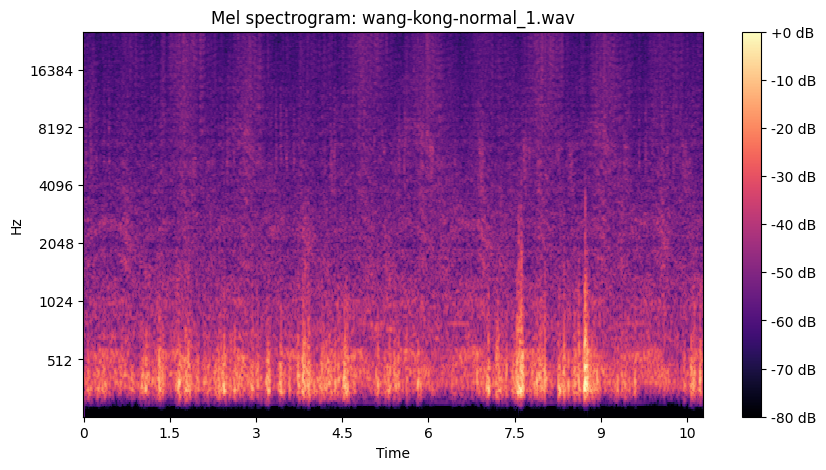

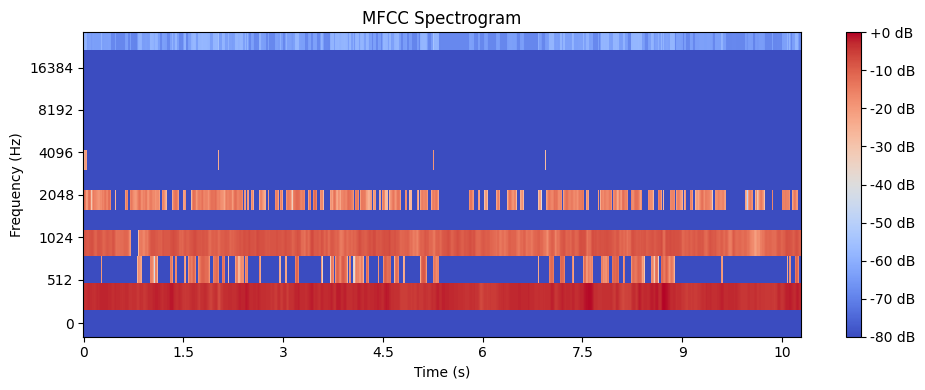

In [8]:
# 指定 STFT 參數
hop_length = 256
n_mels = 256
n_fft = 4096
fmax = 25600
sr=target_sample_rate
n_mfcc=13
dct_type=2
norm='ortho'
lifter=0
mel_spectrogram = convert_to_mel_spectrogram(highpass_audio[0][0], n_fft, hop_length, n_mels, target_sample_rate)
plot_mel_spectrogram(mel_spectrogram, sr=sr, fmax=fmax, hop_length=hop_length, filename=highpass_audio[0][1])
mfccs = extract_mfcc(highpass_audio[0][0], sr=sr, n_mfcc=n_mfcc, dct_type=dct_type, norm=norm, lifter=lifter, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
#Displaying  the MFCCs:
plot_mfcc_spectrogram(mfccs, sr=sr, fmax=fmax, hop_length=hop_length, filename=highpass_audio[0][1])

Number of peaks: 6


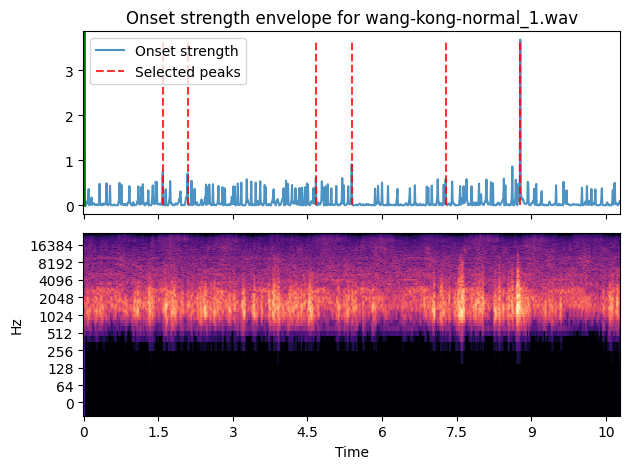

KeyboardInterrupt: 

In [52]:
import matplotlib.animation as animation
from IPython.display import HTML, Audio

def plot_onset_detection(wav_file, sr, n_mfcc=13, dct_type=2, norm='ortho', lifter=0, n_fft=2048, hop_length=512, n_mels=128, fmax=12800):

    wav, name = wav_file
    onset_env = librosa.onset.onset_strength(
        y=wav, sr=sr,
        feature=extract_mfcc,
        n_mfcc=n_mfcc, dct_type=dct_type, norm=norm, lifter=lifter, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax
    )
    
    peaks = librosa.util.peak_pick(onset_env, pre_max=20, post_max=20, pre_avg=50, post_avg=50, delta=0.5, wait=30)
    print(f'Number of peaks: {len(peaks)}')
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)

    fig, ax = plt.subplots(nrows=2, sharex=True)
    mel = convert_to_mel_spectrogram(wav, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, sr=sr, fmax=fmax)
    librosa.display.specshow(mel, sr=sr, y_axis='log', x_axis='time', ax=ax[1], x_coords=times, fmin=25)
    
    ax[0].plot(times, onset_env, alpha=0.8, label='Onset strength')
    if len(peaks) > 0:
        ax[0].vlines(times[peaks], 0, onset_env.max(), color='r', alpha=0.8, label='Selected peaks', linestyle='--')
    ax[0].legend(frameon=True, framealpha=0.8)
    ax[0].label_outer()
    ax[0].set(title=f'Onset strength envelope for {name}')
    plt.tight_layout()
    
    # 創建時間指針
    line, = ax[0].plot([], [], '-', color='green', linewidth=2)
    
    # 更新時間指針的函數
    def update(frame):
        t = frame / sr
        line.set_data([t, t], [0, 8000])
        return line,
    
    # 創建動畫
    ani = animation.FuncAnimation(fig, update, frames=len(wav), interval=1000 / sr, blit=True, repeat=False)
    plt.show()
    return ani
    

# 呼叫函式並傳遞參數
animations = plot_onset_detection(highpass_audio[0], sr=target_sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
display.display(HTML(animations.to_html5_video(embed_limit=20.0)))

In [153]:
def segment_audio(wav_file, segment_length=2, hop_length=512, nfcc=13, n_fft=2048, n_mels=128, fmax=8000):
    """
    Segment audio into clips based on onset detection.

    :param wav: Tuple containing the audio time series data and name of the file (y, name)
    :param segment_length: The desired length of each audio segment in seconds (default: 2)
    :return: A tuple containing a list of audio segments and the sample rate (segments, sr)
    """
    # 載入音訊數據
    y, name = wav_file
    sr = target_sample_rate
    
    # 計算 onset envelope
    onset_env = librosa.onset.onset_strength(
        y=y, sr=sr,

    )
    
    # 找出 onset 的峰值位置
    peaks = librosa.util.peak_pick(onset_env, pre_max=20, post_max=20, pre_avg=50, post_avg=50, delta=0.5, wait=30)
    
    # 將峰值位置轉換為時間戳
    peak_times = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length, n_fft=n_fft)
    
    # 切割音訊,每個片段長度固定為 segment_length 秒
    segments = []
    for peak_time in peak_times:
        # 根據 peak_time 和 segment_length 計算起始和結束時間
        start_time = max(0, peak_time - segment_length / 2)
        end_time = min(peak_time + segment_length / 2, len(y) / sr)
        
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)
        segment = y[start_sample:end_sample]
        
        # 如果片段長度不足 segment_length 秒,則補零
        if len(segment) < segment_length * sr:
            padding_length = int(segment_length * sr) - len(segment)
            segment = np.pad(segment, (0, padding_length), mode='constant')
        
        segments.append(segment)
    
    return segments

In [66]:
# Use Case
segments = segment_audio(loaded_files[1], segment_length=2, hop_length=hop_length, nfcc=n_mfcc, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
print(f'Number of segments: {len(segments)}')


Number of segments: 5


In [73]:
seg_idx = 1
display.Audio(segments[0], rate=target_sample_rate)

# 在同一張圖上繪製所有片段的頻譜圖

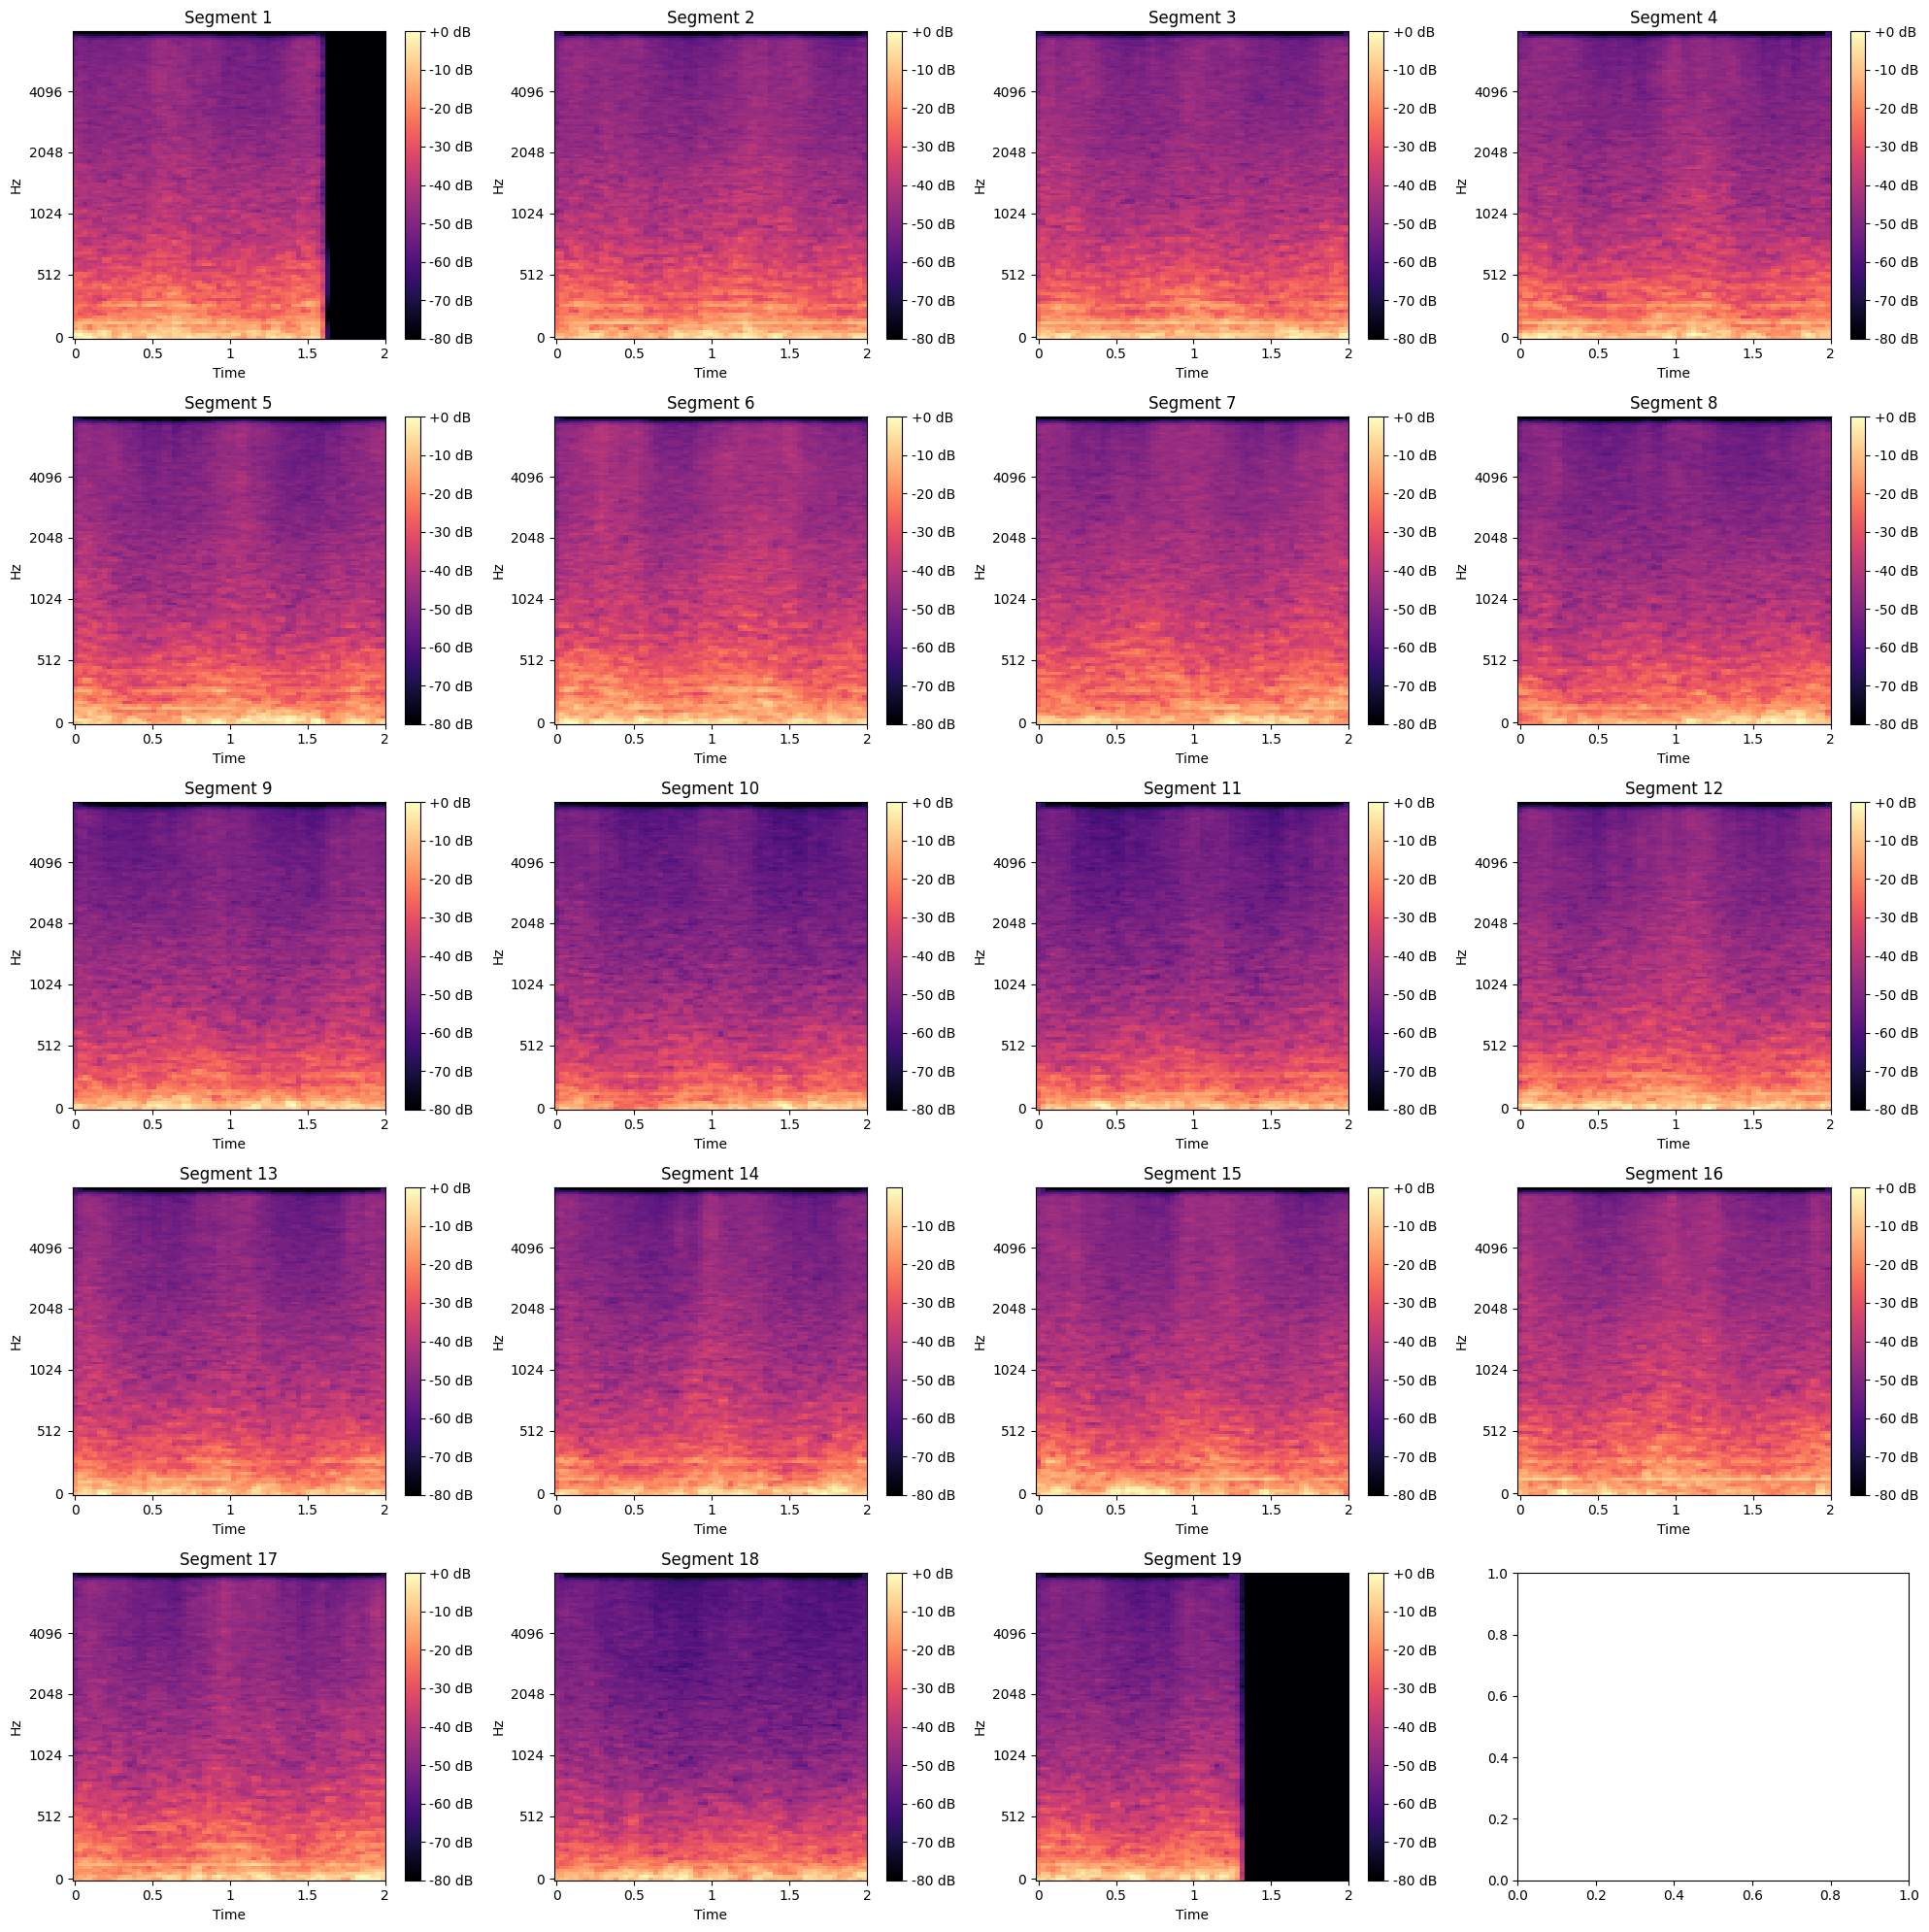

In [13]:
num_segments = len(segments)
num_cols = 4
num_rows = int(np.ceil(num_segments / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig.subplots_adjust(hspace=0.8) # 設置子圖之間的垂直間距
for seg_idx in range(num_segments):
    plt.subplot(num_rows, num_cols, seg_idx + 1)
    # 繪製梅爾導數頻譜圖
    mel_spectrogram = convert_to_mel_spectrogram(segments[seg_idx], n_fft, hop_length, n_mels, target_sample_rate)
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.title(f'Segment {seg_idx + 1}')
    plt.colorbar(format='%+2.0f dB')
    
plt.savefig('segmented_spectrograms.png')
plt.tight_layout()
plt.show()

In [14]:
output_dir = "segmented_audio"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

total_files = len(loaded_files)
with tqdm(total=total_files, desc='Processing files', unit='file') as pbar:
    for i, wav in enumerate(loaded_files):
        segments = segment_audio(wav)
        main_file_name = wav[1].split('.')[0]
        pbar.set_postfix(file=f'{wav[1]}/{total_files}', segments=len(segments))
        for j, segment in enumerate(segments):
            file_name = f'{main_file_name}_segment_{j}.wav'
            sf.write(f'{output_dir}/{file_name}', segment, target_sample_rate)
        pbar.update(1)

Processing files: 100%|██████████| 1232/1232 [01:54<00:00, 10.73file/s, file=34A-8-50-2_Mic111.wav/1232, segments=18] 
